In [176]:
# Kerakli kutubxonalarni yuklash kodi
##################################################################

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import time

#Interface uchun kerak bo'ladigan kutubxona
import ipywidgets as pw
plt.rcParams["font.family"] = "Palatino Linotype"

##################################################################

In [2]:
# Ma'lumotlarni yuklash va kerakli ko'rinishga keltirish kodi.
##################################################################

west_to_east = pd.read_csv('west_to_east.csv')
west_to_east.drop(['Unnamed: 0'], axis=1, inplace=True)
west_to_east['DateTime'] = pd.to_datetime(west_to_east['DateTime'])

##################################################################

In [3]:
# Kerakli o'zgaruvchilarni  yaratib olamiz.
##################################################################

x = [i for i in range(24)] # grafikni barcha x oqlarini chiqarish uchun kerak!
color = ['#646464', '#787878', '#8c8c8c', '#A0A0A0', '#B4B4B4', '#B2B2B2', '#B0B0B0'] # ranglar ro'yxati
u_color = ['#68A225', '#739F3D', '#AA4B41','#217CA3']
select_day = pd.DataFrame() # bo'sh dataframe uchun.

##################################################################

In [4]:
# Datasetni chop etish
##################################################################

print(west_to_east)

##################################################################

                DateTime  Junction  Vehicles  day  week  month  year  hour
0    2023-01-01 00:00:00         1       340    1     6      1  2023     0
1    2023-01-01 01:00:00         1       320    1     6      1  2023     1
2    2023-01-01 02:00:00         1       320    1     6      1  2023     2
3    2023-01-01 03:00:00         1       280    1     6      1  2023     3
4    2023-01-01 04:00:00         1       280    1     6      1  2023     4
...                  ...       ...       ...  ...   ...    ...   ...   ...
4337 2023-06-30 17:00:00         1      2100   30     4      6  2023    17
4338 2023-06-30 18:00:00         1      1920   30     4      6  2023    18
4339 2023-06-30 19:00:00         1      1800   30     4      6  2023    19
4340 2023-06-30 20:00:00         1      1680   30     4      6  2023    20
4341 2023-06-30 21:00:00         1      1560   30     4      6  2023    21

[4342 rows x 8 columns]


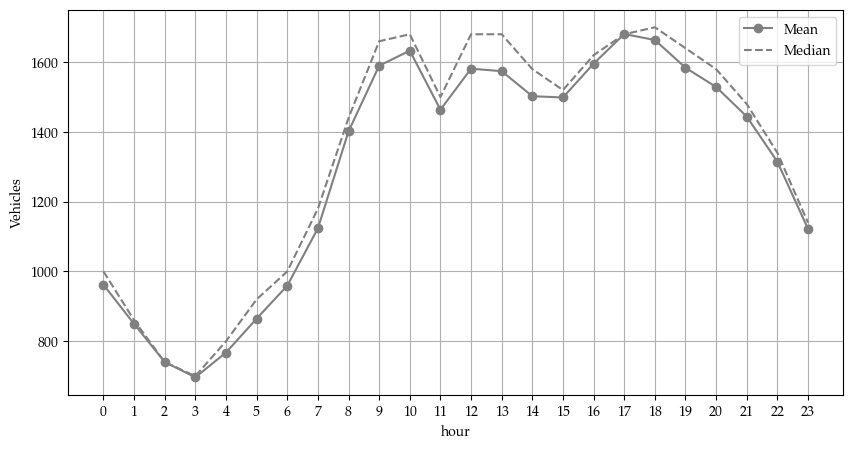

In [24]:
# Datasetdan o'rcha 24 soat ichidagi mashinalar qatnovining 
# o'rtacha qiymatini va mediasini topish va grafik 
# qurish kodi.
##################################################################

west_to_east_by_hours = west_to_east.groupby('hour') # soat bo'yicha guruhlash

west_to_east_averages = pd.DataFrame(
    {
    "Mean": west_to_east_by_hours.mean()['Vehicles'], # o'rtacha qiymati
    "Median":west_to_east_by_hours.median()['Vehicles'] # medianasi
    })

west_to_east_averages.plot(style=['-o','--'], linewidth=1.5, color='gray', grid=True, ylabel = 'Vehicles')
plt.rcParams["figure.figsize"] = (8,5)

plt.xticks(x);
plt.savefig("mean.jpg", dpi=600)
plt.show()

##################################################################

In [5]:
# Tanlangan hafta kunlari.
# Tanlangan oy -- aprel, tanlangan kunlar 1-8 sanalar.
##################################################################

conditions = ((west_to_east['month'] == 4) & (west_to_east['day'] < 8)) # shartlar 
west_to_east_select_week = west_to_east.loc[conditions] # asosiy datasetdan shart bo'yicha ma'lumotni olish
select_day['hour'] = west_to_east_select_week[west_to_east_select_week['day'] == 1]['hour']
for i in range(1, 8):
    select_day['day'+ str(i)] =  west_to_east_select_week[west_to_east_select_week['day'] == i]['Vehicles'].values
    
##################################################################   

In [6]:
# Malumotni chop etish cell   
##################################################################

# select_day
# west_to_east_select_week

    
##################################################################

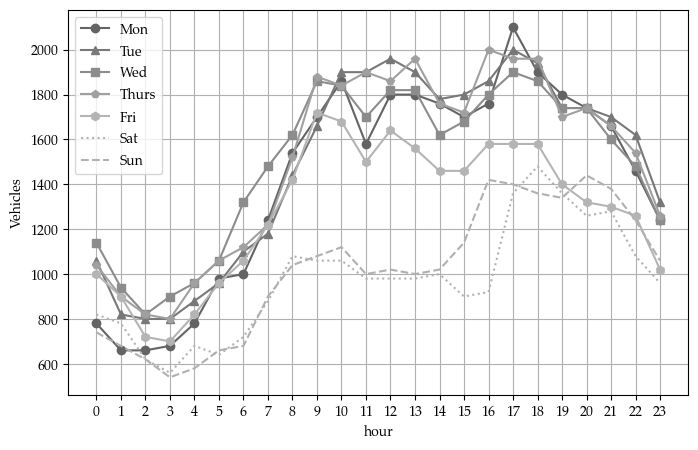

In [27]:
# Malumotni grafigini chop etish cell   
##################################################################

select_day.plot(
             x='hour', y=['day3', 'day4', 'day5', 'day6', 'day7','day1', 'day2', ], 
             style=['-o', '-^',  '-s', '-p', '-h', ':','--',], color=color, grid=True,
             label=['Mon', 'Tue', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'],
             ylabel = 'Vehicles'
             )
plt.xticks(x);
plt.savefig("week.jpg", dpi=600)
plt.show()

##################################################################

# ---------- Modellar ---------- 

### Decision Tree model

In [74]:
# Datasetimizni train testlarga bo'lib olamiz. buning uchun 
# from sklearn.model_selection import train_test_split ishlatamiz
##################################################################

conditions = (west_to_east['month'] < 6)
train_data = west_to_east.loc[conditions]
X = train_data.drop(['Vehicles', 'DateTime'], axis=1)
y = train_data[['Vehicles']]

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state = 20)

# bundan tashqari o'zimizning test ma'lumotimizni ham yaratib olamiz.

conditions = (west_to_east['month'] == 6) & (west_to_east['day'] == 10) #shartlar oy iyun, kun 10.06.2023
X_uniq_test = west_to_east[conditions] # ma'lumot asosiy datasetdan olinadi
Y_uniq_test = X_uniq_test[['Vehicles']]
X_uniq_test  = X_uniq_test.drop(['Vehicles', 'DateTime'], axis=1) #kerak bo'lmagban ma'lumotlar o'chiriladi

##################################################################

In [90]:
# Kiratiladigan maydon
##################################################################

tree_max_depth_text = pw.IntText(value=3, description='Max_depth:')
tree_max_depth_text

##################################################################

IntText(value=3, description='Max_depth:')

In [186]:
# DecisionTreeRegressor modelini qo'llash
##################################################################

# Modelga kerak bo'ladigan o'zgaruvchilarni yaratib olamiz
# tree_max_depth = 3
tree_max_depth = tree_max_depth_text.value
# modelni yaratib olamiz
decision_tree = DecisionTreeRegressor(max_depth=tree_max_depth) # model yaratamiz.

# modelni o'rgatamiz
start_time = time.time()
decision_tree = decision_tree.fit(X_train, Y_train.values.ravel()) 
end_time = time.time()
# bashorat qilamiz train_test_split yordamida yaratilgan ma'lumot boyicha
decision_tree_pred = decision_tree.predict(X_test)

# bashorat qilamiz o'zimiz yaratgan ma'lumot boyicha
# bu yerda training testga qo'shilmagan ma'lumotlar bashorat qilinishi
# uchun uniqe_test dan foydalanamiz.!!!
decision_tree_pred_uniq = decision_tree.predict(X_uniq_test)
print(end_time - start_time)
##################################################################

0.038935184478759766


### RandomForest model

In [200]:
# Kiratiladigan maydon
##################################################################

rf_max_depth_text = pw.IntText(value=50, description='Max_depth:')
rf_n_estimators_text = pw.IntText(value=500, description='N_estimators:')
display(rf_max_depth_text, rf_n_estimators_text)
##################################################################

IntText(value=50, description='Max_depth:')

IntText(value=500, description='N_estimators:')

In [209]:
# RandomForestRegressor modelini qo'llash
##################################################################

# Modelga kerak bo'ladigan o'zgaruvchilarni yaratib olamiz
# rf_max_depth=50
# rf_n_estimators=500

rf_max_depth=rf_max_depth_text.value
rf_n_estimators=rf_n_estimators_text.value

# modelni yaratib olamiz
random_forest = RandomForestRegressor(max_depth=rf_max_depth, n_estimators=rf_n_estimators) # model yaratamiz.

# modelni o'rgatamiz
start_time = time.time()
random_forest = random_forest.fit(X_train, Y_train.values.ravel()) 
end_time = time.time()
# bashorat qilamiz train_test_split yordamida yaratilgan ma'lumot boyicha
random_forest_pred = random_forest.predict(X_test)

# bashorat qilamiz o'zimiz yaratgan ma'lumot boyicha
# bu yerda training testga qo'shilmagan ma'lumotlar bashorat qilinishi
# uchun uniqe_test dan foydalanamiz.!!!
random_forest_pred_uniq = random_forest.predict(X_uniq_test)
print(end_time - start_time)
##################################################################

10.925916910171509


### Gradient boosting

In [69]:
# Kiratiladigan maydon
##################################################################

g_max_depth_text = pw.IntText(value=5, description='Max_depth:')
g_learning_rate_text = pw.FloatText(value=0.1, description='Lear_rate:',step=0.0001)
g_n_estimators_text = pw.IntText(value=500, description='N_estimators:')
display(g_max_depth_text, g_learning_rate_text, g_n_estimators_text)
##################################################################

IntText(value=5, description='Max_depth:')

FloatText(value=0.1, description='Lear_rate:', step=0.0001)

IntText(value=500, description='N_estimators:')

In [339]:
# GradientBoostingRegressor modelini qo'llash
##################################################################

# Modelga kerak bo'ladigan o'zgaruvchilarni yaratib olamiz
# g_max_depth = 5
# g_learning_rate = 0.1
# g_n_estimators = 500 

g_max_depth = g_max_depth_text.value
g_learning_rate = g_learning_rate_text.value
g_n_estimators = g_n_estimators_text.value 
# learning_rate=g_learning_rate,
# modelni yaratib olamiz
gradient_boosting = GradientBoostingRegressor(max_depth=g_max_depth, 
                                              n_estimators=g_n_estimators) # model yaratamiz.

# modelni o'rgatamiz
start_time = time.time()
gradient_boosting = gradient_boosting.fit(X_train, Y_train.values.ravel()) 
end_time = time.time()

# bashorat qilamiz train_test_split yordamida yaratilgan ma'lumot boyicha
gradient_boosting_pred = gradient_boosting.predict(X_test)

# bashorat qilamiz o'zimiz yaratgan ma'lumot boyicha
# bu yerda training testga qo'shilmagan ma'lumotlar bashorat qilinishi
# uchun uniqe_test dan foydalanamiz.!!!
gradient_boosting_pred_uniq =  gradient_boosting.predict(X_uniq_test)
print(end_time - start_time)
##################################################################

4.505115747451782


# ---------- Grafikalar---------- 

In [10]:
# O'lchamlarni chop etish
##################################################################

print(X_test.shape,  Y_test.shape)
print(X_uniq_test.shape, decision_tree_pred_uniq.shape)

##################################################################

(725, 6) (725, 1)
(24, 6) (24,)


## DecisionTreeRegressor

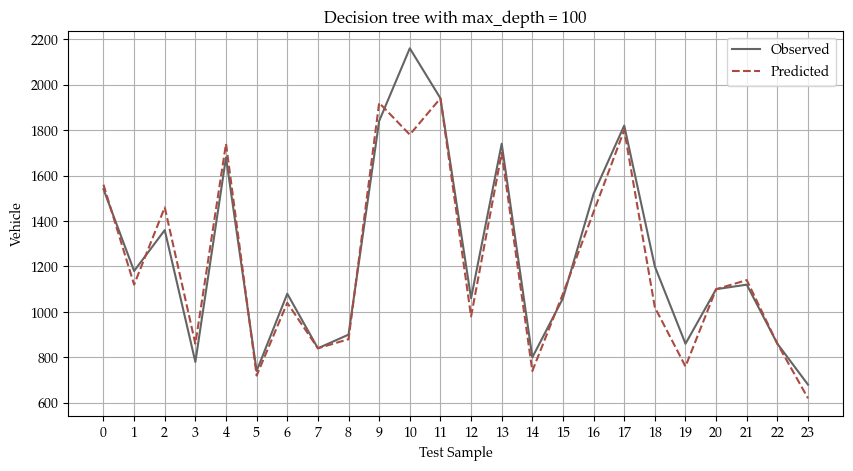

In [173]:
# DecisionTreeRegressor modelining grafigini chiqarish X_test Y_test uchun
##################################################################
x_in = [i for i in range(725)]
x_dim = 24
plt.title(f'Decision tree with max_depth = {tree_max_depth}')
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(x_in[:x_dim],  Y_test[:x_dim], color= color[0], label='Observed')
plt.plot(x_in[:x_dim],  decision_tree_pred[:x_dim], color= u_color[2], ls='dashed', label='Predicted')
plt.legend()
plt.grid()
plt.xlabel('Test Sample')
plt.ylabel('Vehicle')
plt.xticks(x_in[:x_dim]);
plt.savefig(f'./images/Decision_tree_{tree_max_depth}a.jpg', dpi=600)
plt.show()

##################################################################

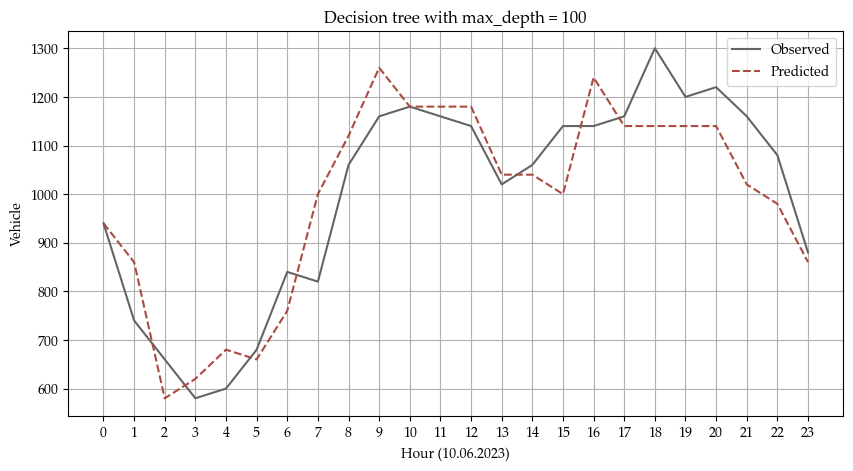

In [174]:
# DecisionTreeRegressor modelining grafigini chiqarish X_uniq_test Y_uniq_test uchun
##################################################################

plt.title(f'Decision tree with max_depth = {tree_max_depth}')
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(X_uniq_test['hour'],  Y_uniq_test, color= color[0], label='Observed')
plt.plot(X_uniq_test['hour'],  decision_tree_pred_uniq, color= u_color[2], ls='dashed', label='Predicted')
plt.legend()
plt.grid()
plt.xticks(x);
plt.xlabel('Hour (10.06.2023)')
plt.ylabel('Vehicle')
plt.savefig(f'./images/Decision_tree_{tree_max_depth}b.jpg', dpi=600)
plt.show()

##################################################################

## RandomForest

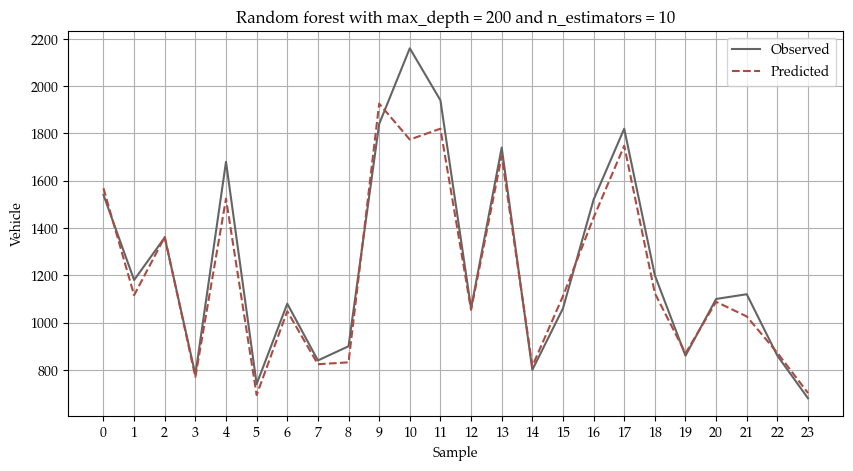

In [165]:
# RandomForestRegressor modelining grafigini chiqarish X_test Y_test uchun
##################################################################
x_in = [i for i in range(725)]
plt.title(f'Random forest with max_depth = {rf_max_depth} and n_estimators = {rf_n_estimators}')
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(x_in[:x_dim],  Y_test[:x_dim], color= color[0], label='Observed')
plt.plot(x_in[:x_dim],  random_forest_pred[:x_dim], color= u_color[2], ls='dashed', label='Predicted')
plt.legend()
plt.grid()
plt.xlabel('Sample')
plt.ylabel('Vehicle')
plt.xticks(x_in[:x_dim]);
plt.savefig(f'./images/Random_forest_{rf_n_estimators}_{rf_max_depth}a.jpg', dpi=600)
plt.show()

##################################################################

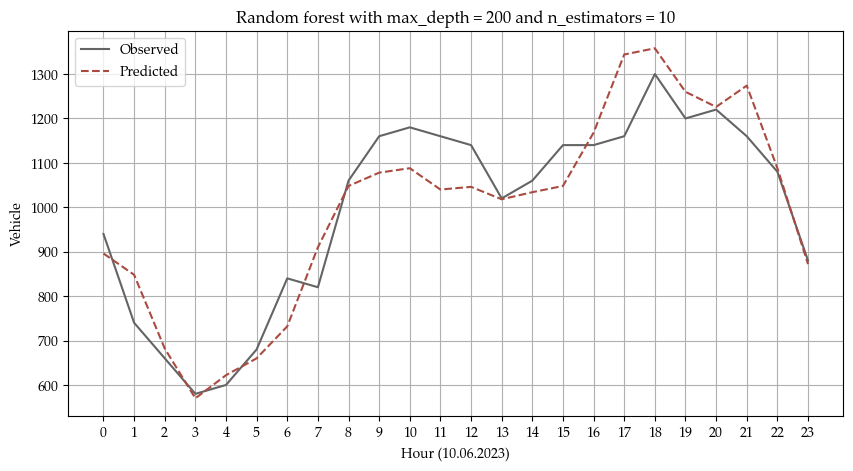

In [166]:
# RandomForestRegressor modelining grafigini chiqarish X_uniq_test Y_uniq_test uchun
##################################################################

plt.title(f'Random forest with max_depth = {rf_max_depth} and n_estimators = {rf_n_estimators}')
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(X_uniq_test['hour'],  Y_uniq_test, color= color[0], label='Observed')
plt.plot(X_uniq_test['hour'],   random_forest_pred_uniq, color= u_color[2], ls='dashed', label='Predicted')
plt.legend()
plt.grid()
plt.xlabel('Hour (10.06.2023)')
plt.ylabel('Vehicle')
plt.xticks(x);
plt.savefig(f'./images/Random_forest_{rf_n_estimators}_{rf_max_depth}b.jpg', dpi=600)
plt.show()

##################################################################

## GradientBoostingRegressor

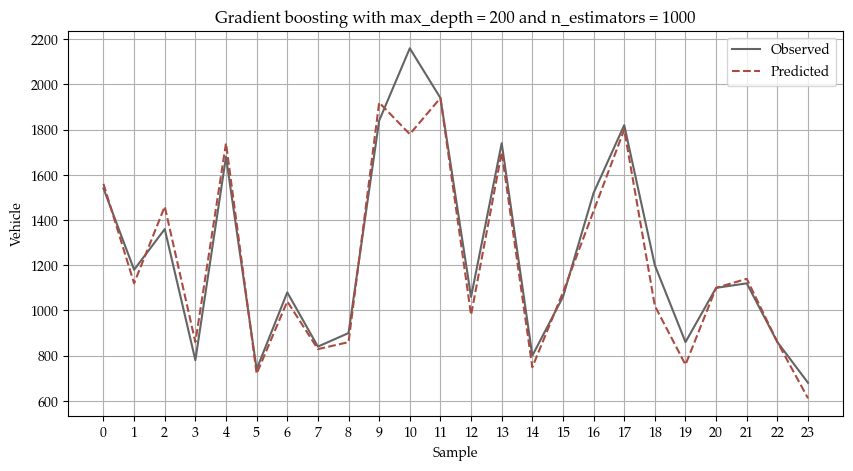

In [340]:
# GradientBoostingRegressor modelining grafigini chiqarish X_test Y_test uchun
##################################################################
x_in = [i for i in range(725)]
plt.title(f'Gradient boosting with max_depth = {g_max_depth} and n_estimators = {g_n_estimators}')
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(x_in[:x_dim],  Y_test[:x_dim], color= color[0], label='Observed')
plt.plot(x_in[:x_dim],  gradient_boosting_pred[:x_dim], color= u_color[2], ls='dashed', label='Predicted')
plt.legend()
plt.grid()
plt.xlabel('Sample')
plt.ylabel('Vehicle')
# plt.xticks(x_in[:100]);
plt.xticks(x);
plt.savefig(f'./images/Gradient_boosting_{g_n_estimators}_{g_max_depth}a.jpg', dpi=600)
plt.show()

##################################################################

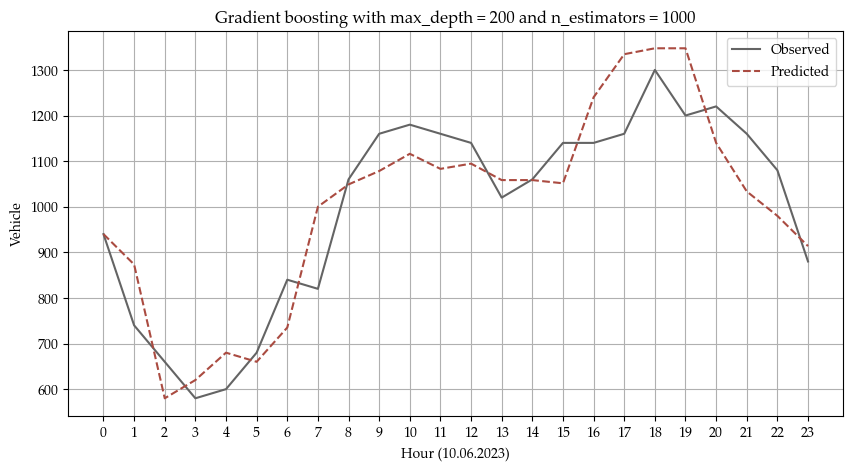

In [341]:
# GradientBoostingRegressor grafigini chiqarish X_uniq_test Y_uniq_test uchun
##################################################################

plt.title(f'Gradient boosting with max_depth = {g_max_depth} and n_estimators = {g_n_estimators}')
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(X_uniq_test['hour'],  Y_uniq_test, color= color[0], label='Observed')
plt.plot(X_uniq_test['hour'],   gradient_boosting_pred_uniq, color= u_color[2], ls='dashed', label='Predicted')
plt.legend()
plt.grid()
plt.xlabel('Hour (10.06.2023)')
plt.ylabel('Vehicle')
plt.xticks(x);
plt.savefig(f'./images/Gradient_boosting_{g_n_estimators}_{g_max_depth}b.jpg', dpi=600)
plt.show()

##################################################################

# Training R<sup>2</sup> Xatolik

### Decision Tree

In [175]:
# xatoliklarnini aniqlash kodi
##################################################################

# R squared Error
train_error_score = metrics.r2_score(Y_test[:x_dim], decision_tree_pred[:x_dim])
print("R squared Error - Training for Y_test : ", train_error_score)

train_error_score = metrics.r2_score(Y_uniq_test, decision_tree_pred_uniq)
print("R squared Error - Training for Y_uniq_test : ", train_error_score)


# MSE
train_error_score = metrics.mean_squared_error(Y_test[:x_dim], decision_tree_pred[:x_dim])
print("Mean squared error - Training for Y_test : ", train_error_score)

train_error_score = metrics.mean_squared_error(Y_uniq_test, decision_tree_pred_uniq)
print("Mean squared error - Training for Y_uniq_test : ", train_error_score)


# MAE
train_error_score = metrics.mean_absolute_error(Y_test[:x_dim], decision_tree_pred[:x_dim])
print("Mean absolute error - Training for Y_test : ", train_error_score)

train_error_score = metrics.mean_absolute_error(Y_uniq_test, decision_tree_pred_uniq)
print("Mean absolute error - Training for Y_uniq_test : ", train_error_score)

##################################################################

R squared Error - Training for Y_test :  0.943909446769124
R squared Error - Training for Y_uniq_test :  0.8339074803149606
Mean squared error - Training for Y_test :  10100.0
Mean squared error - Training for Y_uniq_test :  7500.0
Mean absolute error - Training for Y_test :  63.333333333333336
Mean absolute error - Training for Y_uniq_test :  70.0


### Random Forest

In [167]:
# xatoliklarnini aniqlash kodi
##################################################################

train_error_score = metrics.r2_score(Y_test[:x_dim], random_forest_pred[:x_dim])
print("R squared Error - Training for Y_test : ", train_error_score)

train_error_score = metrics.r2_score(Y_uniq_test, random_forest_pred_uniq)
print("R squared Error - Training for Y_uniq_test : ", train_error_score)

# MSE
train_error_score = metrics.mean_squared_error(Y_test[:x_dim], random_forest_pred[:x_dim])
print("Mean squared error - Training for Y_test : ", train_error_score)

train_error_score = metrics.mean_squared_error(Y_uniq_test, random_forest_pred_uniq)
print("Mean squared error - Training for Y_uniq_test : ", train_error_score)

# MAE
train_error_score = metrics.mean_absolute_error(Y_test[:x_dim], random_forest_pred[:x_dim])
print("Mean absolute error - Training for Y_test : ", train_error_score)

train_error_score = metrics.mean_absolute_error(Y_uniq_test, random_forest_pred_uniq)
print("Mean absolute error - Training for Y_uniq_test : ", train_error_score)

##################################################################

R squared Error - Training for Y_test :  0.9447267398137257
R squared Error - Training for Y_uniq_test :  0.8733009350393701
Mean squared error - Training for Y_test :  9952.833333333334
Mean squared error - Training for Y_uniq_test :  5721.166666666667
Mean absolute error - Training for Y_test :  62.416666666666664
Mean absolute error - Training for Y_uniq_test :  58.75


### Gradient  boosting

In [296]:
# Gradient boosting xatoliklarnini aniqlash kodi
##################################################################

train_error_score = metrics.r2_score(Y_test[:x_dim], gradient_boosting_pred[:x_dim])
print("R squared Error - Training for Y_test : ", train_error_score)

train_error_score = metrics.r2_score(Y_uniq_test, gradient_boosting_pred_uniq)
print("R squared Error - Training for Y_uniq_test : ", train_error_score)

# MSE
train_error_score = metrics.mean_squared_error(Y_test[:x_dim], gradient_boosting_pred[:x_dim])
print("Mean squared error - Training for Y_test : ", train_error_score)

train_error_score = metrics.mean_squared_error(Y_uniq_test, gradient_boosting_pred_uniq)
print("Mean squared error - Training for Y_uniq_test : ", train_error_score)

# MAE
train_error_score = metrics.mean_absolute_error(Y_test[:x_dim], gradient_boosting_pred[:x_dim])
print("Mean absolute error - Training for Y_test : ", train_error_score)

train_error_score = metrics.mean_absolute_error(Y_uniq_test, gradient_boosting_pred_uniq)
print("Mean absolute error - Training for Y_uniq_test : ", train_error_score)


##################################################################

R squared Error - Training for Y_test :  0.7731964782636209
R squared Error - Training for Y_uniq_test :  0.6832805229239671
Mean squared error - Training for Y_test :  40839.596644885
Mean squared error - Training for Y_uniq_test :  14301.643942633309
Mean absolute error - Training for Y_test :  152.0970126993078
Mean absolute error - Training for Y_uniq_test :  94.40242150811055


# Regressor parametrlarini aniqlash kodi

In [28]:
# RandomForest parametrlarini aniqlash kodi
# Boshlang'chi parametrlarni kiritib olamiz.
##################################################################

param_grid = {
    'max_depth':[2, 3, 5, 7, 10, 50, 100],
    'n_estimators':[10, 50, 100, 500]
}

##################################################################
# Modelni tanlab olamiz
##################################################################

rf_param = GridSearchCV(random_forest, param_grid, cv = 3, n_jobs=-1)
rf_param.fit(X_train, Y_train.values.ravel())

##################################################################

print(rf_param.best_params_, rf_param.best_score_ )

{'max_depth': 50, 'n_estimators': 500} 0.9341432440763141


In [29]:
# GradientBoostingRegressor parametrlarini aniqlash kodi
# Boshlang'chi parametrlarni kiritib olamiz.
##################################################################

param_grid = {
    'max_depth':[2, 3, 5, 7, 9],
    'learning_rate' : [0.001, 0.01, 0.1, 0.2, 0.4, 0.5], 
    'n_estimators':[10, 50, 100, 500]
}

##################################################################
# Modelni tanlab olamiz
##################################################################

gbr_param = GridSearchCV(gradient_boosting, param_grid, cv = 3, n_jobs=-1)
gbr_param.fit(X_train, Y_train.values.ravel())

##################################################################

print(gbr_param.best_params_, gbr_param.best_score_ )

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500} 0.9481562560920964


[Text(0.5, 0.875, 'hour <= 7.5\nsamples = 2899\nvalue = 1261.821'),
 Text(0.25, 0.625, 'week <= 4.5\nsamples = 986\nvalue = 859.006'),
 Text(0.125, 0.375, 'hour <= 5.5\nsamples = 709\nvalue = 927.757'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'hour <= 6.5\nsamples = 277\nvalue = 683.032'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'week <= 4.5\nsamples = 1913\nvalue = 1469.441'),
 Text(0.625, 0.375, 'hour <= 20.5\nsamples = 1362\nvalue = 1637.342'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'hour <= 15.5\nsamples = 551\nvalue = 1054.41'),
 Text(0.8125, 0.125, '\n  (...)  \n'),
 Text(0.9375, 0.125, '\n  (...)  \n')]

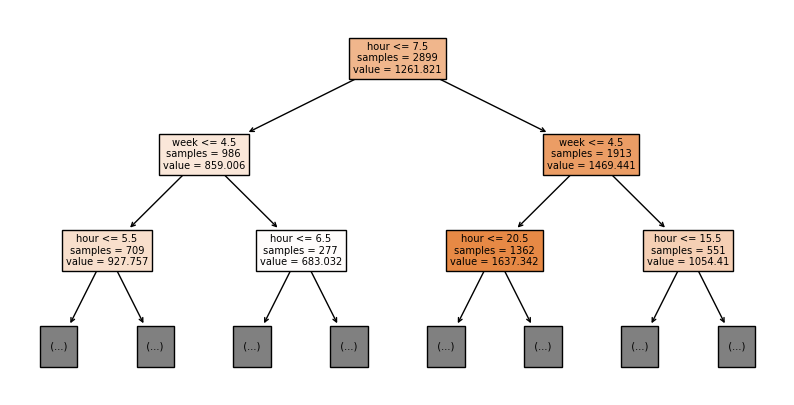

In [34]:
# DecisionTreeRegressor modelining daraxsimon grafigini chiqarish
##################################################################
plot_tree(decision_tree, feature_names = ['Junction', 'day', 'week', 'month', 'year', 'hour'], 
                impurity=False, filled=True, max_depth=2) 

In [32]:
plot_tree

<function sklearn.tree._export.plot_tree(decision_tree, *, max_depth=None, feature_names=None, class_names=None, label='all', filled=False, impurity=True, node_ids=False, proportion=False, rounded=False, precision=3, ax=None, fontsize=None)>